In [122]:
# Access Log converting Text to CSV
# Rule Authoring - Labeling Data for Supervised ML 

import re
import sys
import netaddr

# Source Access Log file - Text Format
log_file = "E:/MSIS-AU/Thesis/AIML/Logs_Text/access-2019-05-15.log"

# Destination CSV file with labels
dest_file = "E:/MSIS-AU/Thesis/AIML/Logs_CSV_Labelled/access-2019-05-15.csv"


# Retrieving data form a a http log file (access_log)
def extract_data(log_file):
    regex = '([(\d\.)]+) - - \[(.*?)\] "(.*?)" (\d+) (.+) "(.*?)" "(.*?)"'
    data = {}

    log_file = open(log_file, 'r')

    for log_line in log_file:
        log_line=log_line.replace(',','_')
        
        log_line = re.match(regex,log_line).groups()
        
        size = str(log_line[4]).rstrip('\n')

        ip_addr = log_line[0]        
        ip = netaddr.IPAddress(ip_addr)        
        ip_addr_num = ip.value
        
        data_size = int(size)
        
        return_code = log_line[3]

        url = log_line[2]

        param_number = len(url.split('&'))

        url_length = len(url)

        if '-' in size:
            data_size = 0
        else:
            data_size = int(size)

        if (int(return_code) > 0):
            charcs = {}
            charcs['ip_addr'] = ip_addr
            charcs['ip_addr_num'] = ip_addr_num
            charcs['data_size'] = int(data_size)
            charcs['param_number'] = int(param_number)
            charcs['length'] = int(url_length)
            charcs['return_code'] = int(return_code)
            data[url] = charcs        
    return data


# Label data by adding a new column with two possible values:
# label as 1 for attack or suspecious activity and 0 for normal behaviour

def label_data(data,labeled_data):
    
   
    for w in data:

                
        attack = '0'
        attack_label = 'No'

        # Pattrns for identifying Injections - Can add more patterns
        patterns = ['honeypot', '%3b', 'xss', 'sql', '%3c', '%3e', 'eval', 'select', '1=1', 'update', 'union', 'delete']

        # Black Listed example IP addresses        
                
        black_ips = ['222.186.20.115', '127.0.0.1']
        
       
        if any(pattern in w.lower() for pattern in patterns):
            print "Injection pattern identified"
            attack = '1'
            attack_label = 'Yes'

        if any(blackip in (data[w]['ip_addr']) for blackip in black_ips):
            print "Black IP Address Matched"
            attack = '1'
            attack_label = 'Yes'
        
        if data[w]['data_size'] > 1000000 :
            print "Request Served Having more than 1000000 Bytes of data than set limit"
            attack = '1'
            attack_label = 'Yes'

        data_row = str(data[w]['ip_addr'])+ ',' + str(data[w]['ip_addr_num'])+ ',' + str(data[w]['data_size']) + ',' + str(data[w]['length']) + ',' + str(data[w]['param_number']) + ',' + str(data[w]['return_code']) + ',' + attack + ','+ attack_label + ',' + w + '\n'

        labeled_data.write(data_row)
    print str(len(data)) + ' rows have successfully saved with labels to ' + dest_file
    
    

label_data(extract_data(log_file),open(dest_file, 'w'))


Injection pattern identified
Request Served Having more than 1000000 Bytes of data than set limit
Injection pattern identified
Injection pattern identified
Request Served Having more than 1000000 Bytes of data than set limit
Injection pattern identified
Request Served Having more than 1000000 Bytes of data than set limit
Injection pattern identified
Injection pattern identified
Request Served Having more than 1000000 Bytes of data than set limit
Request Served Having more than 1000000 Bytes of data than set limit
Injection pattern identified
Injection pattern identified
Request Served Having more than 1000000 Bytes of data than set limit
Request Served Having more than 1000000 Bytes of data than set limit
Request Served Having more than 1000000 Bytes of data than set limit
Injection pattern identified
Injection pattern identified
Request Served Having more than 1000000 Bytes of data than set limit
Request Served Having more than 1000000 Bytes of data than set limit
Injection pattern id

In [123]:
# Looking for Sample Records after Conversion

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
logs1  = pd.read_csv("E:/MSIS-AU/Thesis/AIML/Logs_CSV_Labelled/access-2019-05-15.csv", names=['ip', 'ip_num', 'data_size','url_len', 'parameters_no','return_code','attack','attack_label','url_req'])
logs1.head()

,ip,ip_num,data_size,url_len,parameters_no,return_code,attack,attack_label,url_req
0,221.2.44.75,3707907147,239,78,1,404,0,No,GET //admin/FCKeditor/editor/filemanager/conne...
1,221.2.44.75,3707907147,239,92,1,404,0,No,GET //Web_fckeditor/editor/filemanager/browser...
2,213.174.152.182,3584989366,284,51,1,404,0,No,GET /Datasets Description/Network/ftp.html HTT...
3,112.66.18.237,1883378413,294,58,1,404,0,No,POST /admin_aspcms/_system/AspCms_SiteSetting....
4,221.2.44.75,3707907147,239,78,1,404,0,No,GET //admin/FCKeditor/editor/filemanager/conne...


In [124]:
# create a mapping from logs label value for making results easier to interpret
lookup_logs_type = dict(zip(logs1.attack.unique(), logs1.attack_label.unique()))   
lookup_logs_type

{0: 'No', 1: 'Yes'}

In [125]:
# Parameters Setting & Accuracy Score demo using Train Test Split for Supervised ML Algos
from sklearn.neighbors import KNeighborsClassifier

X = logs1[['ip_num', 'data_size', 'url_len', 'parameters_no', 'return_code']]
y = logs1['attack_label']


# Trian Test Split - TTSplit
# Default is 75% / 25% train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


# KNN  Algo
print "\n\n=-=-=-=-=-=- KNN Classifier -=-=-=-=-=-=-\n"
knn = KNeighborsClassifier(n_neighbors = 3)
print knn.fit(X_train, y_train)
print 'KNN Accuracy Score =>' 
print knn.score(X_test, y_test)


# 2-DECISON TREE Algo
print "\n\n=-=-=-=-=-=- Decision Tree Classifier -=-=-=-=-=-=-\n"
dt = tree.DecisionTreeClassifier()
print dt.fit(X_train, y_train)
print 'Decision Tree Accuracy Score =>' 
print dt.score(X_test, y_test)

# 3-LOGISTIC REGRESSION Algo
print "\n\n=-=-=-=-=-=-=- Logistic Regression Classifier -=-=-=-=-=-\n"
lr = linear_model.LogisticRegression(C = 100, solver='lbfgs')
print lr.fit(X_train, y_train)
print 'Logistic Regression Accuracy Score =>' 
print lr.score(X_test, y_test)


# 4-SVM Algo
print "\n\n=-=-=-=-=-=-=-=-=-=-=-=- SVM Classifier -=-=-=-=-=-=-=-=-=-=-\n"
X1 = logs1[['url_len', 'parameters_no', 'return_code']]
y1 = logs1['attack_label']
# Trian Test Split - TTSplit
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=0)
sv = svm.SVC(kernel='linear') # Linear Kernel
print sv.fit(X1_train, y_train)
print 'SVM Accuracy Score =>' 
print sv.score(X1_test, y1_test)





=-=-=-=-=-=- KNN Classifier -=-=-=-=-=-=-

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')
KNN Accuracy Score =>
0.94776119403


=-=-=-=-=-=- Decision Tree Classifier -=-=-=-=-=-=-

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Decision Tree Accuracy Score =>
0.962686567164


=-=-=-=-=-=-=- Logistic Regression Classifier -=-=-=-=-=-

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, ver

In [126]:
import sys
import numpy as np
from sklearn import tree, linear_model, svm


def get_data_details(csv_data):
        data = np.genfromtxt(csv_data, delimiter = ",")
                
        features = data[:, [1,2,3,4,5]]
        labels = data[:, 6]
        
        
        return features, labels

def get_occuracy(real_labels, predicted_labels, fltr):
        real_label_count = 0.0
        predicted_label_count = 0.0

        for real_label in real_labels:
                if real_label == fltr:
                        real_label_count += 1

        for predicted_label in predicted_labels:
                if predicted_label == fltr:
                        predicted_label_count += 1

        print "Real number of attacks: " + str(real_label_count)
        print "Predicted number of attacks: " + str(predicted_label_count)

        precision = predicted_label_count * 100 / real_label_count
        return precision
print "Done This"

Done This


In [127]:
# Supervised Learning - Train and Predict on Same File
# Demo of supervised  ML Algos to predict intrusion/suspecious activities in http logs


traning_data = "E:/MSIS-AU/Thesis/AIML/Logs_CSV_Labelled/access-2019-05-15.csv"
testing_data = "E:/MSIS-AU/Thesis/AIML/Logs_CSV_Labelled/access-2019-05-15.csv"


# Get training features and labeles
training_features, traning_labels = get_data_details(traning_data)

# Get testing features and labels
testing_features, testing_labels = get_data_details(testing_data)


# 1-KNN  Algo
print "\n\n=-=-=-=-=-=-=- KNN Classifier -=-=-=-=-=-=-=-\n"

# Instanciate the classifier
attack_classifier = KNeighborsClassifier(n_neighbors=3)
# Train the classifier
attack_classifier = attack_classifier.fit(training_features, traning_labels)
# Get predections for the testing data
predictions = attack_classifier.predict(testing_features)
print "The precision of the KNN Classifier is: " + str(get_occuracy(testing_labels,predictions, 1)) + "%"


# 2-DECISON TREE Algo
print "\n\n=-=-=-=-=-=- Decision Tree Classifier -=-=-=-=-=-=-\n"

# Instanciate the classifier
attack_classifier1 = tree.DecisionTreeClassifier()
# Train the classifier
attack_classifier1 = attack_classifier1.fit(training_features, traning_labels)
# Get predections for the testing data
predictions1 = attack_classifier1.predict(testing_features)
print "The precision of the Decision Tree Classifier is: " + str(get_occuracy(testing_labels,predictions1, 1)) + "%"


# 3-LOGISTIC REGRESSION Algo
print "\n\n=-=-=-=-=-=-=- Logistic Regression Classifier -=-=-=-=-=-\n"

# Instanciate the classifier
attack_classifier2 = linear_model.LogisticRegression(C = 100, solver='lbfgs')
# Train the classifier
attack_classifier2.fit(training_features, traning_labels)
# Get predections for the testing data
predictions2 = attack_classifier2.predict(testing_features)
print "The precision of the Logistic Regression Classifier is: " + str(get_occuracy(testing_labels,predictions2, 1)) + "%"








=-=-=-=-=-=-=- KNN Classifier -=-=-=-=-=-=-=-

Real number of attacks: 46.0
Predicted number of attacks: 39.0
The precision of the KNN Classifier is: 84.7826086957%


=-=-=-=-=-=- Decision Tree Classifier -=-=-=-=-=-=-

Real number of attacks: 46.0
Predicted number of attacks: 45.0
The precision of the Decision Tree Classifier is: 97.8260869565%


=-=-=-=-=-=-=- Logistic Regression Classifier -=-=-=-=-=-

Real number of attacks: 46.0
Predicted number of attacks: 21.0
The precision of the Logistic Regression Classifier is: 45.652173913%


In [128]:
# 4-SVM CLASSIFIER Algo
# Very slow on large numeric values - features reduced

def get_data_SVM(csv_data):
        data = np.genfromtxt(csv_data, delimiter = ",")               
        features = data[:, [3,4,5]]
        labels = data[:, 6]    
        
        return features, labels
    
# Get training features and labeles
training_features, traning_labels = get_data_SVM(traning_data)

# Get testing features and labels
testing_features, testing_labels = get_data_SVM(testing_data)

print "\n\n=-=-=-=-=-=-=- SVM Classifier -=-=-=-=-=-\n"
# Instanciate the classifier
attack_classifier3 = svm.SVC(kernel='linear') # Linear Kernel
# Train the classifier
attack_classifier3.fit(training_features, traning_labels)
# Get predections for the testing data
predictions3 = attack_classifier3.predict(testing_features)
print "The precision of the SVM Classifier is: " + str(get_occuracy(testing_labels,predictions3, 1)) + "%"



=-=-=-=-=-=-=- SVM Classifier -=-=-=-=-=-

Real number of attacks: 46.0
Predicted number of attacks: 14.0
The precision of the SVM Classifier is: 30.4347826087%


<IPython.core.display.Javascript object>


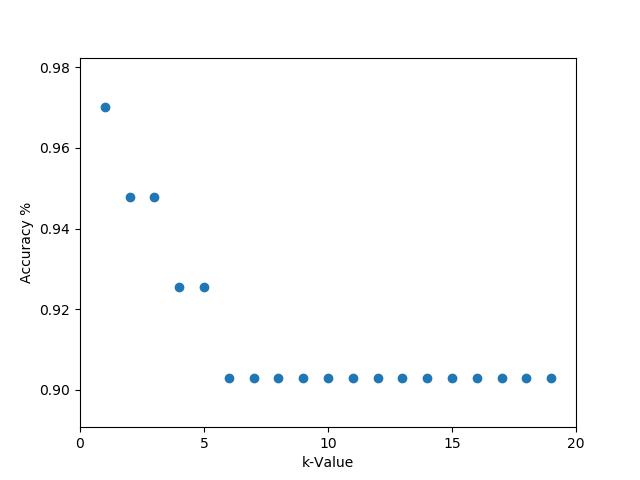

([<matplotlib.axis.XTick at 0x100a2db0>,
 <a list of 5 Text xticklabel objects>)

In [129]:
# Accuracy Plot for Different Values of K in KNN
k_range = range(1,20)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

plt.figure()
plt.xlabel('k-Value')
plt.ylabel('Accuracy %')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20]);
#plt.yticks([0.5,0.6,0.7,0.8,0.9,1])